# Notebook 3 — Treino, Avaliação e Análise (Ambiente Original vs. Ambiente Modificado)

## Objetivo

Neste notebook realizamos a **fase experimental final** do trabalho:

1. **Treinar** um agente de RL (Stable-Baselines3) no ambiente **original** (*BipedalWalker-v3*).
2. **Avaliar** o mesmo agente no ambiente original **e** no ambiente **modificado** (*InjuredBipedalWalker*).
3. **Treinar** um agente diretamente no ambiente modificado para obter um **limite superior** (*upper bound*) do desempenho naquele cenário.
4. **Comparar** curvas e métricas finais, discutindo **como** e **porquê** as alterações no ambiente afetam a aprendizagem e o comportamento do agente.

> Nota metodológica: a análise das **curvas** (treino) e das **avaliações determinísticas** (teste) é mantida separada.  
> As curvas indicam tendências e estabilidade durante a aprendizagem; a avaliação determinística confirma o desempenho final e a consistência do comportamento.

In [1]:
import sys
import os
# Adicionar pasta pai ao path para encontrar o my_envs
sys.path.append(os.path.abspath(".."))

import gymnasium as gym
import my_envs # O teu ambiente da perna partida (InjuredBipedalWalker-v0)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import TD3 # Importamos apenas o Vencedor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
# Configuração visual
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Criar pastas para a Fase 3
os.makedirs("../models/fase3_injured", exist_ok=True)
os.makedirs("../logs/fase3_injured", exist_ok=True)

print("Ambiente e bibliotecas carregados com sucesso!")



Ambiente e bibliotecas carregados com sucesso!


No notebook anterior analisamos qual melhor algoritmo e o melhro conjunto de hiper parametros no ambiemte baseline, ou seja, bipedalwalker-v3. Os resultados que obtivemos foram então como algoitmo mais promissor o TD3 e melhor configuração míope, ou seja, lr=0.001 e gama = 0.98.

In [4]:
# algoritmo com melhor performance na fase anterior
ALGO_NAME = "TD3"
# modelo saudável treinado na fase 2
PATH_MODELO_BASELINE = "../models/tun_selection/TD3_Miope.zip" 
# Verificar se o modelo saudável existe e está acessível
if not os.path.exists(PATH_MODELO_BASELINE):
    print(f"AVISO: Não encontrei o modelo em '{PATH_MODELO_BASELINE}'.")
else:
    print(f"Modelo basline encontrado: {PATH_MODELO_BASELINE}")

Modelo basline encontrado: ../models/tun_selection/TD3_Miope.zip


Agora vamos fazer uma avaliação determinística do modelo baseline no ambiente original bipedalwalker-v3 e 

## 1.1. Teste de Robustez

Nesta primeira experiência,vamos carregar o modelo do agente que aprendeu a caminhar com sucesso no ambiente normal (o "cérebro saudável") e colocá-lo a controlar o robô no ambiente modificado (o "corpo lesionado"), sem qualquer treino adicional.

Este cenário simula uma falha mecânica súbita em tempo de execução (como um motor que perde força a meio de uma tarefa), onde o agente não tem oportunidade prévia de se readaptar.

**Objetivo:** Avaliar a **robustez** da política aprendida. Queremos quantificar a queda de desempenho imediata para responder à pergunta: será que o agente consegue compensar a assimetria utilizando apenas o conhecimento adquirido no ambiente saudável, ou a falha será catastrófica?

--- A AVALIAR ---
1. Agente Saudável em Ambiente Normal...


c:\Users\Utilizador\Desktop\Sistemas\bipedal-walker\.venv\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


   -> Reward: 235.22
2. Agente Saudável em Ambiente Lesionado...
   -> Reward: -51.30


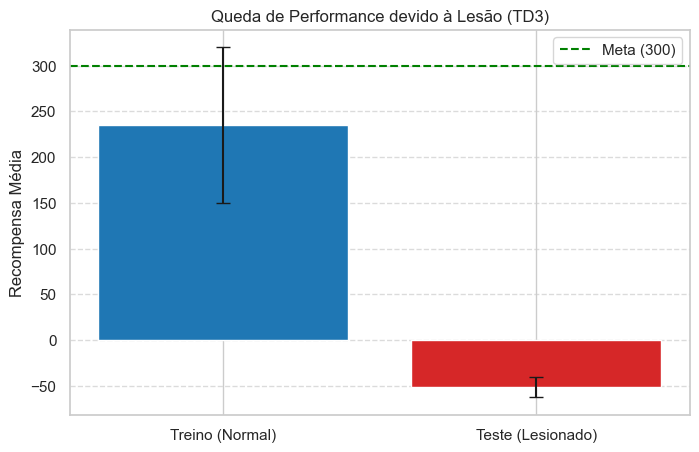

,Cenário,Reward,Std
0,Treino (Normal),235.221109,84.809686
1,Teste (Lesionado),-51.296916,11.059173


In [ ]:
if os.path.exists(PATH_MODELO_SAUDAVEL):
    # 1. Carregar Modelo
    model_healthy = TD3.load(PATH_MODELO_SAUDAVEL)
    
    # 2. Definir Ambientes
    env_normal = gym.make("BipedalWalker-v3")
    env_injured = gym.make("InjuredBipedalWalker-v0")
    
    print("--- A AVALIAR ---")
    
    # 3. Avaliar no Normal (Baseline)
    print("1. Agente Saudável em Ambiente Normal...")
    mean_norm, std_norm = evaluate_policy(model_healthy, env_normal, n_eval_episodes=20)
    print(f"   -> Reward: {mean_norm:.2f}")
    
    # 4. Avaliar no Injured (Robustez)
    print("2. Agente Saudável em Ambiente Lesionado...")
    mean_inj, std_inj = evaluate_policy(model_healthy, env_injured, n_eval_episodes=20)
    print(f"   -> Reward: {mean_inj:.2f}")
    
    env_normal.close()
    env_injured.close()

# 5. Visualizar
    df_robustness = pd.DataFrame([
        {"Cenário": "Treino (Normal)", "Reward": mean_norm, "Std": std_norm},
        {"Cenário": "Teste (Lesionado)", "Reward": mean_inj, "Std": std_inj}
    ])
    
    plt.figure(figsize=(8, 5))
    
    # Criar o gráfico de barras com as barras de erro
    bars = plt.bar(
        df_robustness["Cenário"], 
        df_robustness["Reward"], 
        yerr=df_robustness["Std"], 
        capsize=5, 
        color=['#1f77b4', '#d62728'] # Azul para normal, Vermelho para lesionado
    )
    
    plt.title(f"Queda de Performance devido à Lesão ({ALGO_NAME})")
    plt.axhline(300, color="green", linestyle="--", label="Meta (300)")
    plt.ylabel("Recompensa Média")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.show()
    
    display(df_robustness)




## 1.2. Teste de Adaptação (Re-Treino)

Após avaliarmos a resposta imediata à falha, investigamos agora a capacidade de **adaptação** do algoritmo. Nesta experiência, vamos treinar um **novo agente TD3 de raiz** diretamente no ambiente `InjuredBipedalWalker-v0`.

Ao contrário do modelo anterior, que tentava aplicar uma marcha normal a um corpo avariado, este novo agente terá a oportunidade de aprender, desde o primeiro passo, que a perna direita possui apenas 30% da potência.

**Objetivo:** Determinar o "teto de desempenho" possível no ambiente lesionado. Queremos verificar se, com treino dedicado, o algoritmo é capaz de descobrir uma estratégia motora alternativa que lhe permita recuperar a eficiência perdida, servindo de termo de comparação para o modelo saudável.


In [ ]:
# Configuração do Treino
TIMESTEPS = 300_000 
SEED = 0

print(f"--- A TREINAR NOVO TD3 NO AMBIENTE 'INJURED' ---")

# Criar ambiente modificado
env = gym.make("InjuredBipedalWalker-v0")
eval_env = gym.make("InjuredBipedalWalker-v0")

# Setup do Modelo
save_path = f"../models/fase3_injured/TD3_injured_seed{SEED}"
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=save_path,
    log_path=f"../logs/fase3_injured",
    eval_freq=10000,
    deterministic=True,
    render=False,
    verbose=1
)

try:
    model_injured = TD3("MlpPolicy", env, verbose=0, seed=SEED, tensorboard_log="../logs/fase3_injured")
    
    model_injured.learn(total_timesteps=TIMESTEPS, callback=eval_callback, tb_log_name="TD3_Injured_Run")
    # Guardar final
    model_injured.save(f"{save_path}/final_model")
    print("Treino concluído com sucesso!")
    
except Exception as e:
    print(f"Erro durante o treino: {e}")
finally:
    env.close()
    eval_env.close()



--- A TREINAR NOVO TD3 NO AMBIENTE 'INJURED' ---


c:\Users\Utilizador\Desktop\Sistemas\bipedal-walker\.venv\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-93.17 +/- 3.56
Episode length: 97.60 +/- 14.15
New best mean reward!
Eval num_timesteps=20000, episode_reward=-120.92 +/- 5.54
Episode length: 94.20 +/- 18.53
Eval num_timesteps=30000, episode_reward=-103.12 +/- 0.12
Episode length: 52.40 +/- 0.49
Eval num_timesteps=40000, episode_reward=-114.87 +/- 0.84
Episode length: 83.40 +/- 0.80
Eval num_timesteps=50000, episode_reward=-64.09 +/- 33.56
Episode length: 1325.00 +/- 550.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=-84.59 +/- 10.56
Episode length: 1600.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=-81.93 +/- 31.72
Episode length: 1337.00 +/- 526.00
Eval num_timesteps=80000, episode_reward=-86.09 +/- 29.28
Episode length: 1011.20 +/- 721.13
Eval num_timesteps=90000, episode_reward=-101.90 +/- 11.75
Episode length: 1600.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=-70.58 +/- 16.56
Episode length: 1600.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=-34

## 1.3. Resultados Finais: Recuperação da Performance

Os dados recolhidos após as experiências de Robustez e Adaptação permitem-nos agora determinar a magnitude do impacto da falha mecânica, bem como a eficácia do treino específico na recuperação da performance.

O gráfico apresentado abaixo compara a recompensa média obtida em três cenários distintos:

1.  **Baseline (Referência):** O desempenho ideal do agente saudável no ambiente normal (**~235 pontos**).
2.  **Robustez (Zero-Shot):** O desempenho do agente saudável quando colocado no ambiente lesionado (**~ -51 pontos**).
3.  **Adaptação (Re-Treino):** O desempenho do novo agente treinado especificamente para lidar com a lesão (**~ -8.6 pontos**).

### Análise dos Dados

Os resultados permitem-nos retirar três conclusões fundamentais sobre a interação entre o algoritmo TD3 e a falha mecânica:

1.  **A Falha de Robustez é Catastrófica:** A transição do cenário 1 para o 2 revela uma degradação de performance. O agente, habituado a pernas simétricas, não consegue generalizar a sua locomoção para o corpo avariado, resultando em quedas constantes e incapacidade de progredir no terreno.
2.  **O Treino Especializado Mitiga a Falha:** A experiência de Adaptação demonstra uma recuperação notável face ao cenário de robustez (subindo de **-51** para **-8.6**). Isto prova que o algoritmo se adapta o suficiente para aprender uma estratégia de sobrevivência que evita o pior cenário.
3.  **O Limite Mecânico Persiste:** Apesar da melhoria, o agente adaptado não recuperou a performance original (+235). O valor de -8.6 indica que o robô consegue manter-se de pé por mais tempo, mas a perda de 70% de potência na perna direita impõe um teto físico severo à velocidade e eficiência da locomoção.

### Conclusão e Próximos Passos

Concluímos que o agente consegue adaptar-se parcialmente às novas restrições do ambiente, transformando aquilo que seria uma falha crítica numa operação degradada mas ainda funcional.

Ainda assim, o algoritmo TD3 na versão padrão (com os hiperparâmetros default) parece ter ficado preso num ótimo local, que não chega para atingir os 300 pontos necessários para considerar o ambiente resolvido.

Para tentar ultrapassar este limite e explorar melhor o potencial do agente lesionado, no passo seguinte vamos avançar para a otimização de hiperparâmetros (tuning), afinando o processo de aprendizagem do modelo à maior dificuldade deste novo cenário físico.


A carregar Agente Adaptado...


c:\Users\Utilizador\Desktop\Sistemas\bipedal-walker\.venv\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_6364\992501786.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_data, x="Estado", y="Reward", palette=["green", "red", "blue"])


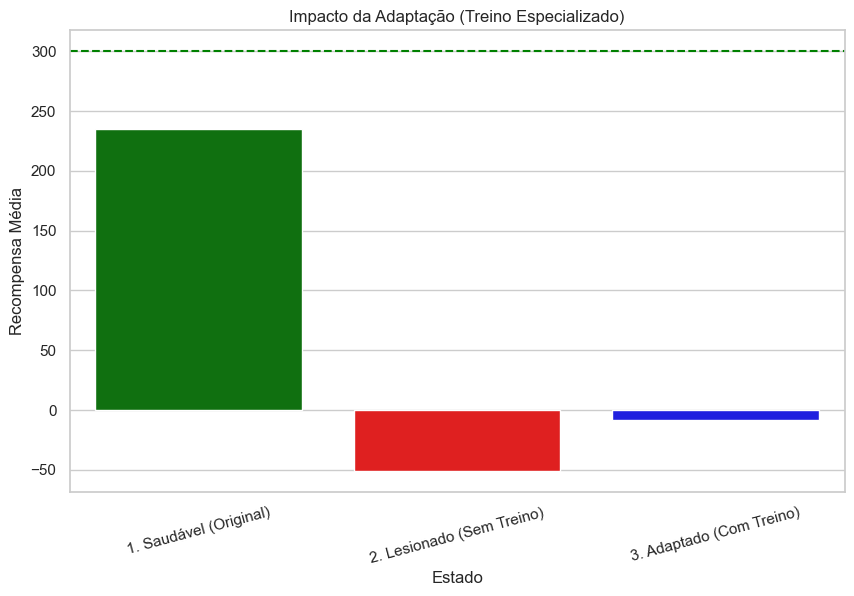

,Estado,Ambiente,Reward
0,1. Saudável (Original),Normal,235.221109
1,2. Lesionado (Sem Treino),Injured,-51.296916
2,3. Adaptado (Com Treino),Injured,-8.653439


In [9]:
# Carregar o melhor modelo treinado agora
best_injured_model_path = f"../models/fase3_injured/TD3_injured_seed{SEED}/best_model.zip"

if os.path.exists(best_injured_model_path):
    print("A carregar Agente Adaptado...")
    model_adapted = TD3.load(best_injured_model_path)
    
    # Avaliar
    env_inj = gym.make("InjuredBipedalWalker-v0")
    mean_adapt, std_adapt = evaluate_policy(model_adapted, env_inj, n_eval_episodes=20)
    env_inj.close()
    
    # Construir dados finais (reutilizando variáveis da célula 5)
    if 'mean_norm' in locals():
        final_data = pd.DataFrame([
            {"Estado": "1. Saudável (Original)", "Ambiente": "Normal", "Reward": mean_norm},
            {"Estado": "2. Lesionado (Sem Treino)", "Ambiente": "Injured", "Reward": mean_inj},
            {"Estado": "3. Adaptado (Com Treino)", "Ambiente": "Injured", "Reward": mean_adapt}

        ])
        plt.figure(figsize=(10, 6))
        sns.barplot(data=final_data, x="Estado", y="Reward", palette=["green", "red", "blue"])
        plt.title("Impacto da Adaptação (Treino Especializado)")
        plt.axhline(300, color="green", linestyle="--", label="Meta (300)")
        plt.ylabel("Recompensa Média")
        plt.xticks(rotation=15)
        plt.show()
        
        display(final_data)
    else:
        print("Corre a célula 5 primeiro para ter os dados de comparação.")
else:
    print("Modelo adaptado não encontrado. O treino terminou?")

        
